Loading the shapefile...
<bound method NDFrame.head of          wd11cd                                     wd11nm  \
0     E05000001                                 Aldersgate   
2     E05000002                                    Aldgate   
3     E05000003                                  Bassishaw   
4     E05000004                               Billingsgate   
5     E05000005                                Bishopsgate   
...         ...                                        ...   
1221  E05007402                       Tatsfield and Titsey   
1222  E05007404  Warlingham East and Chelsham and Farleigh   
1224  E05007405                            Warlingham West   
1225  E05007406                                    Westway   
1226  E05007407                                 Whyteleafe   

                                               geometry  
0     POLYGON ((532097.1 182012.799, 532104.4 182011...  
2     POLYGON ((533470.1 181404.799, 533509.399 1813...  
3     POLYGON ((532544.799

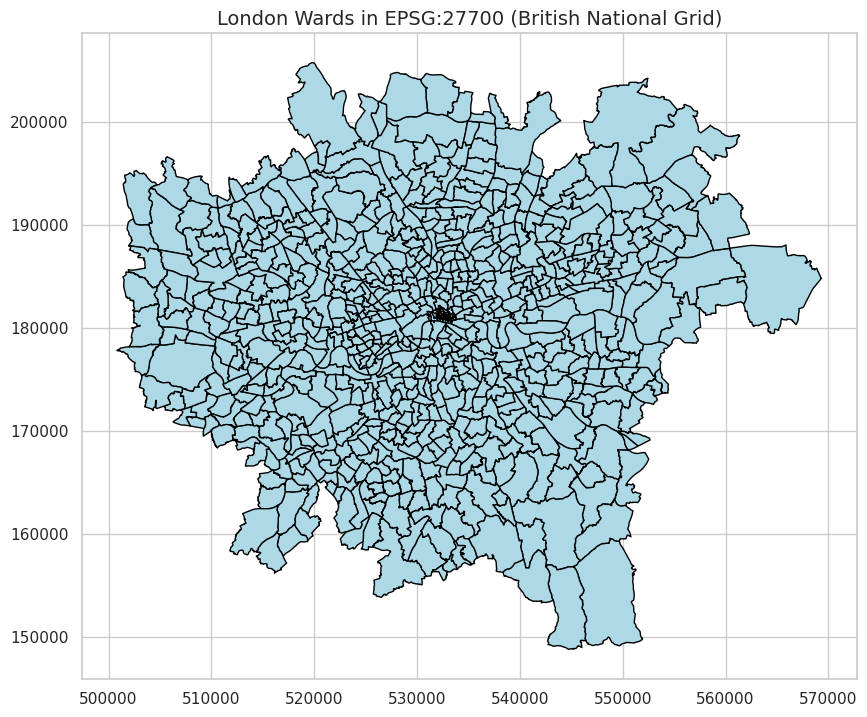

In [165]:
import geopandas as gpd  
import matplotlib.pyplot as plt  

wards_file = "data/London_Wards_Final_Cleaned.shp"  
print("Loading the shapefile...")  
wards = gpd.read_file(wards_file) 

wards = wards.drop_duplicates(subset=["wd11cd"], keep="first")
wards = wards[["wd11cd", "wd11nm", "geometry"]]  
print(wards.head) 

wards = wards.to_crs(epsg=27700)  
fig, ax = plt.subplots(figsize=(10, 10))  
wards.plot(ax=ax, color="lightblue", edgecolor="black")  
ax.set_title("London Wards in EPSG:27700 (British National Grid)", fontsize=14)  
plt.show()  

In [166]:
import pandas as pd  

green_space = pd.read_csv("data/access-public-open-space-ward2013.csv")  
Athletics = pd.read_csv("data/GIS_Active_Places_Power_Athletics_7326674813535722083.csv", usecols=["Year Built", "Latitude", "Longitude"])  
Cycling = pd.read_csv("data/GIS_Active_Places_Power_Cycling_5488600787265641176.csv", usecols=["Year Built", "Latitude", "Longitude"])  
Gym = pd.read_csv("data/GIS_Active_Places_Power_Health_and_Fitness_6808338834069276551.csv", usecols=["Year Built", "Latitude", "Longitude"])  
outofworkfamilies = pd.read_csv("data/outofworkfamilies_londonward.csv")  
population = pd.read_csv("data/population_london.csv")  

In [167]:
# 1. 移除完全为空的行  
green_space_cleaned = green_space.dropna(how="all")

# 2. 移除无用的列：只保留需要的列  
columns_to_keep = [  
    "WD13CD", "Ward name", "Borough name", "Open Space"       
]  
green_space_cleaned = green_space_cleaned[columns_to_keep]  

green_space_cleaned.columns = green_space_cleaned.columns.str.strip().str.replace(" ", "_").str.lower()  

# 4. 基于核心字段清理：如 `wd13cd` 列存在缺失值的行  
green_space_cleaned = green_space_cleaned.dropna(subset=["wd13cd"])  

# 5. 将数值列转换为合适的数据类型
num_columns = ["open_space"]  
green_space_cleaned[num_columns] = green_space_cleaned[num_columns].apply(pd.to_numeric, errors="coerce")  
green_space_cleaned = green_space_cleaned.rename(columns={"open_space": "open_space_rate"})

# 6. 检查清理后的结果  
print(green_space_cleaned.head()) 

      wd13cd       ward_name          borough_name  open_space_rate
0  E05000026           Abbey  Barking and Dagenham             70.7
1  E05000027          Alibon  Barking and Dagenham              8.0
2  E05000028       Becontree  Barking and Dagenham             39.2
3  E05000029  Chadwell Heath  Barking and Dagenham             63.1
4  E05000030       Eastbrook  Barking and Dagenham             56.7


In [168]:
from shapely.geometry import Point  
import geopandas as gpd  

# 处理 Athletics 数据  
Athletics_filtered = Athletics[Athletics["Year Built"] <= 2013].copy()  
Athletics_filtered["geometry"] = Athletics_filtered.apply(  
    lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)  

# 创建 GeoDataFrame，并先设置为 WGS84 (EPSG:4326)  
Athletics_gdf = gpd.GeoDataFrame(Athletics_filtered, geometry="geometry", crs="EPSG:4326")  

# 转换为英国国家格网 (EPSG:27700)  
Athletics_gdf = Athletics_gdf.to_crs(epsg=27700)  

# 处理 Cycling 数据  
Cycling_filtered = Cycling[Cycling["Year Built"] <= 2013].copy()  
Cycling_filtered["geometry"] = Cycling_filtered.apply(  
    lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)  

Cycling_gdf = gpd.GeoDataFrame(Cycling_filtered, geometry="geometry", crs="EPSG:4326")  
Cycling_gdf = Cycling_gdf.to_crs(epsg=27700)  

# 处理 Gym 数据  
Gym_filtered = Gym[Gym["Year Built"] <= 2013].copy()  
Gym_filtered["geometry"] = Gym_filtered.apply(  
    lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)  

Gym_gdf = gpd.GeoDataFrame(Gym_filtered, geometry="geometry", crs="EPSG:4326")  
Gym_gdf = Gym_gdf.to_crs(epsg=27700)

In [169]:
outofworkfamilies=outofworkfamilies[['New Code','2013']]
outofworkfamilies_filter = outofworkfamilies.rename(columns={"2013": "poverty_kids"})

# 清理 outofworkfamilies 数据  
outofworkfamilies_cleaned = outofworkfamilies_filter.dropna().copy()  # 移除 NaN    
outofworkfamilies_cleaned = outofworkfamilies_cleaned[outofworkfamilies_cleaned["New Code"].str.startswith("E05")]  

# 清理 population 数据  
population=population[['New Code','Population_2013','Age0-18_2013']]
population_cleaned = population.dropna().copy()  # 移除 NaN  
population_cleaned = population_cleaned[population_cleaned["New Code"].str.startswith("E05")]  

# 合并数据框  
merged_poverty = pd.merge(outofworkfamilies_cleaned, population_cleaned, on="New Code", how="inner")  

# 计算贫困儿童比例  
merged_poverty["povertykids_ratio"] = merged_poverty["poverty_kids"] / merged_poverty["Age0-18_2013"]  


povertykids_ratio = merged_poverty[["New Code", "poverty_kids", "Age0-18_2013",'Population_2013',"povertykids_ratio"]]  
print(povertykids_ratio.head())

    New Code  poverty_kids  Age0-18_2013  Population_2013  povertykids_ratio
0  E05000026           990        3500.0          13806.0           0.282857
1  E05000027          1030        2750.0          10527.0           0.374545
2  E05000028          1135        3100.0          12155.0           0.366129
3  E05000029           825        2500.0          10261.0           0.330000
4  E05000030           635        2200.0          10701.0           0.288636


In [170]:
import geopandas as gpd  
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from shapely.geometry import Point  

# 删除不位于 London 边界内的点  
Gym_gdf = Gym_gdf[Gym_gdf.within(wards.unary_union)]  
Cycling_gdf = Cycling_gdf[Cycling_gdf.within(wards.unary_union)]  
Athletics_gdf = Athletics_gdf[Athletics_gdf.within(wards.unary_union)]  

# 1. 空间连接并统计每个 Ward 的 Gym、Cycling、Athletics 点数量  
gym_join = gpd.sjoin(Gym_gdf, wards, how="inner", predicate="intersects")  
cycling_join = gpd.sjoin(Cycling_gdf, wards, how="inner", predicate="intersects")  
athletics_join = gpd.sjoin(Athletics_gdf, wards, how="inner", predicate="intersects")  

# 统计每个 Ward 点数量  
gym_counts = gym_join.groupby("wd11cd").size().rename("gym_count").reset_index()  
cycling_counts = cycling_join.groupby("wd11cd").size().rename("cycling_count").reset_index()  
athletics_counts = athletics_join.groupby("wd11cd").size().rename("athletics_count").reset_index()  

# 合并点数量到 wards  
wards_with_counts = wards.merge(gym_counts, on="wd11cd", how="left").fillna(0)  
wards_with_counts = wards_with_counts.merge(cycling_counts, on="wd11cd", how="left").fillna(0)  
wards_with_counts = wards_with_counts.merge(athletics_counts, on="wd11cd", how="left").fillna(0)  

# 检查点统计结果  
print(wards_with_counts[["wd11cd", "gym_count", "cycling_count", "athletics_count"]].head())  

# 2. 合并 Poverty 数据  
povertykids_ratio.rename(columns={"New Code": "wd11cd"}, inplace=True)  
final_merged = pd.merge(wards_with_counts, povertykids_ratio, on="wd11cd", how="left").fillna(0)  

# 3. 计算比例（避免分母为 0 或 NaN）  
# 将这些列转换为数值类型，如果有非数值内容，用 NaN 替换掉  
final_merged["gym_count"] = pd.to_numeric(final_merged["gym_count"], errors="coerce")  
final_merged["cycling_count"] = pd.to_numeric(final_merged["cycling_count"], errors="coerce")  
final_merged["athletics_count"] = pd.to_numeric(final_merged["athletics_count"], errors="coerce")  
final_merged["Population_2013"] = pd.to_numeric(final_merged["Population_2013"], errors="coerce")
final_merged["Population_2013"] = final_merged["Population_2013"].replace(0, np.nan)  # 避免 0  
# 让比例放大，改为每 10,000 人的设施数量  
final_merged["gym_ratio"] = final_merged["gym_count"] / final_merged["Population_2013"] * 10000  
final_merged["cycling_ratio"] = final_merged["cycling_count"] / final_merged["Population_2013"] * 10000  
final_merged["athletics_ratio"] = final_merged["athletics_count"] / final_merged["Population_2013"] * 10000

# 填充新计算出的比例列中的 NaN （若需展示）  
final_merged[["gym_ratio", "cycling_ratio", "athletics_ratio"]] = final_merged[  
    ["gym_ratio", "cycling_ratio", "athletics_ratio"]  
].fillna(0)  

# 4. 提取需要的列  
final_result = final_merged[  
    ["wd11cd", "wd11nm", "geometry", "gym_ratio", "cycling_ratio", "athletics_ratio", "povertykids_ratio"]  
]  

# 检查最终结果  
print(final_result)  

/tmp/ipykernel_42713/3742354397.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Gym_gdf = Gym_gdf[Gym_gdf.within(wards.unary_union)]
/tmp/ipykernel_42713/3742354397.py:9: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Cycling_gdf = Cycling_gdf[Cycling_gdf.within(wards.unary_union)]
/tmp/ipykernel_42713/3742354397.py:10: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  Athletics_gdf = Athletics_gdf[Athletics_gdf.within(wards.unary_union)]


      wd11cd  gym_count  cycling_count  athletics_count
0  E05000001        2.0            0.0              0.0
1  E05000002        4.0            0.0              0.0
2  E05000003        0.0            0.0              0.0
3  E05000004        0.0            0.0              0.0
4  E05000005        5.0            0.0              0.0
        wd11cd                                     wd11nm  \
0    E05000001                                 Aldersgate   
1    E05000002                                    Aldgate   
2    E05000003                                  Bassishaw   
3    E05000004                               Billingsgate   
4    E05000005                                Bishopsgate   
..         ...                                        ...   
721  E05007402                       Tatsfield and Titsey   
722  E05007404  Warlingham East and Chelsham and Farleigh   
723  E05007405                            Warlingham West   
724  E05007406                                    West

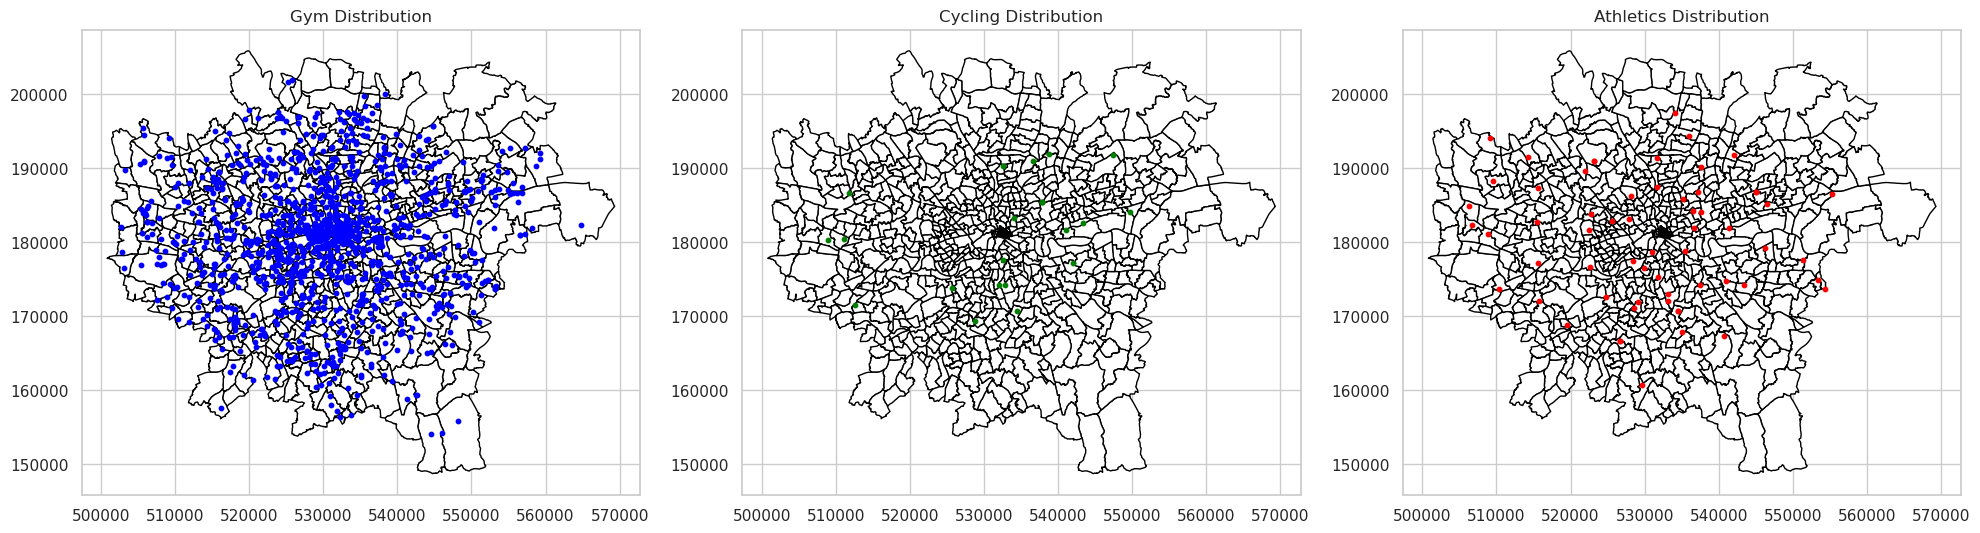

In [171]:
# 绘制各分布图  
fig, axs = plt.subplots(1, 3, figsize=(20, 7))  

# Gym 点分布  
wards.plot(ax=axs[0], color="white", edgecolor="black")  
Gym_gdf.plot(ax=axs[0], color="blue", markersize=10)  
axs[0].set_title("Gym Distribution")  

# Cycling 点分布  
wards.plot(ax=axs[1], color="white", edgecolor="black")  
Cycling_gdf.plot(ax=axs[1], color="green", markersize=10)  
axs[1].set_title("Cycling Distribution")  

# Athletics 点分布  
wards.plot(ax=axs[2], color="white", edgecolor="black")  
Athletics_gdf.plot(ax=axs[2], color="red", markersize=10)  
axs[2].set_title("Athletics Distribution")  

plt.tight_layout()  
plt.show()

In [190]:
green_space_cleaned.rename(columns={"wd13cd": "wd11cd"}, inplace=True)  
green_space_cleaned = green_space_cleaned[["wd11cd","open_space_rate"]]  

# 合并到 final_result，确保保留 final_result 中的所有 wd11cd  
final_result = final_result.merge(green_space_cleaned, on="wd11cd", how="left") 
# 优先整合两个列的值：如果 `_x` 值为空，选择 `_y`  
final_result["open_space_rate"] = final_result["open_space_rate_x"].combine_first(final_result["open_space_rate_y"])  
final_result.drop(columns=["open_space_rate_x", "open_space_rate_y"], inplace=True)  

# 替换 NaN 值为 0  
final_result["open_space_rate"] = final_result["open_space_rate"].fillna(0)

# 检查合并结果  
print(final_result)  

        wd11cd                                     wd11nm  \
0    E05000001                                 Aldersgate   
1    E05000002                                    Aldgate   
2    E05000003                                  Bassishaw   
3    E05000004                               Billingsgate   
4    E05000005                                Bishopsgate   
..         ...                                        ...   
721  E05007402                       Tatsfield and Titsey   
722  E05007404  Warlingham East and Chelsham and Farleigh   
723  E05007405                            Warlingham West   
724  E05007406                                    Westway   
725  E05007407                                 Whyteleafe   

                                              geometry  gym_ratio  \
0    POLYGON ((532097.1 182012.799, 532104.4 182011...        0.0   
1    POLYGON ((533470.1 181404.799, 533509.399 1813...        0.0   
2    POLYGON ((532544.799 181629.6, 532620.397 1816...      

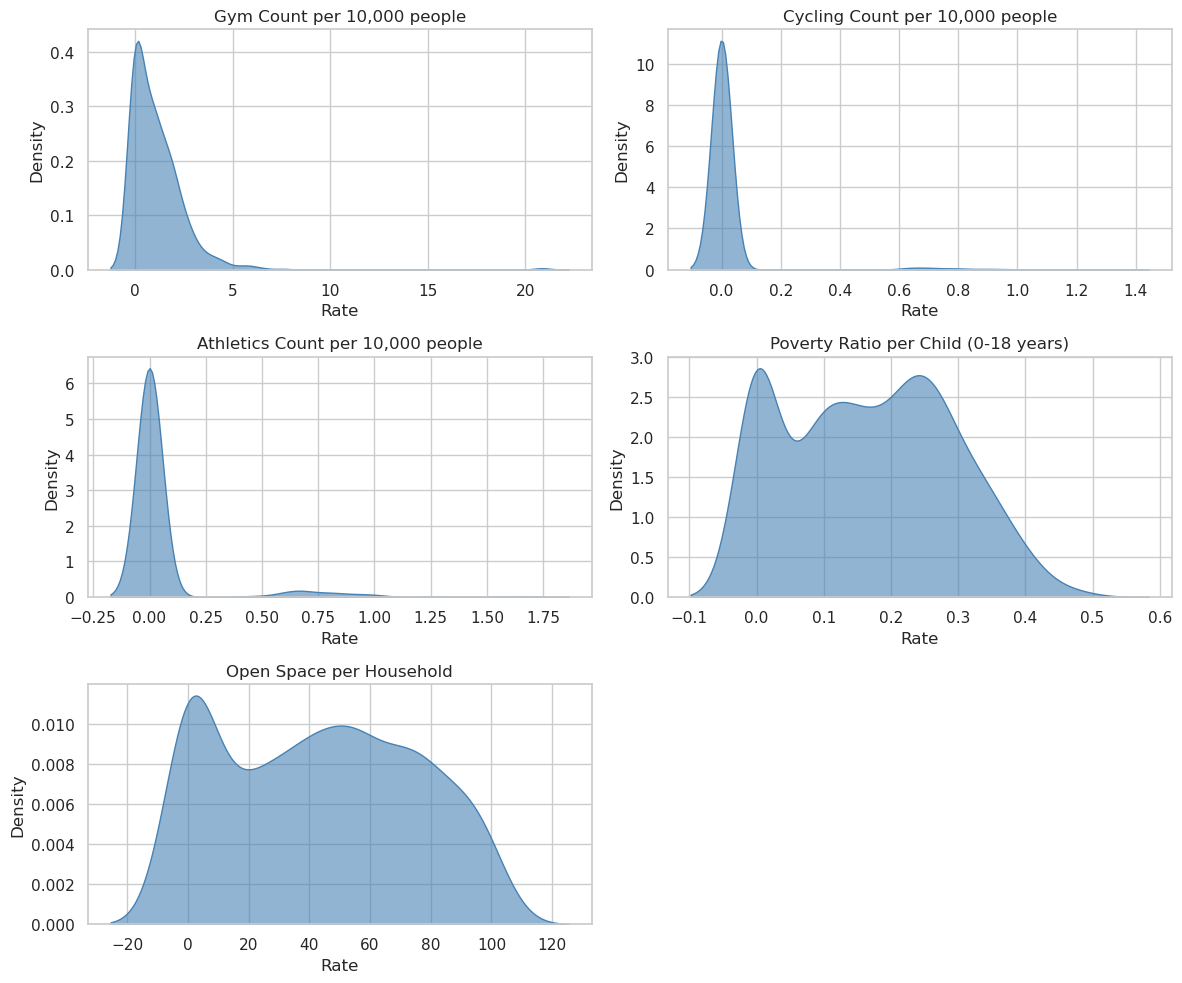

In [191]:
import matplotlib.pyplot as plt  
import seaborn as sns  

# 变量名称及对应单位  
rates_info = {  
    "gym_ratio": "Gym Count per 10,000 people",  
    "cycling_ratio": "Cycling Count per 10,000 people",  
    "athletics_ratio": "Athletics Count per 10,000 people",  
    "povertykids_ratio": "Poverty Ratio per Child (0-18 years)",  
    "open_space_rate": "Open Space per Household"  
}  

# 设置绘图大小  
plt.figure(figsize=(12, 10))  

for i, (col, label) in enumerate(rates_info.items()):  
    plt.subplot(3, 2, i + 1)  # 3x2 网格布局  
    sns.kdeplot(final_result[col], fill=True, color="steelblue", alpha=0.6)  
    plt.title(label, fontsize=12)  
    plt.xlabel("Rate")  
    plt.ylabel("Density")  

plt.tight_layout()  
plt.show()

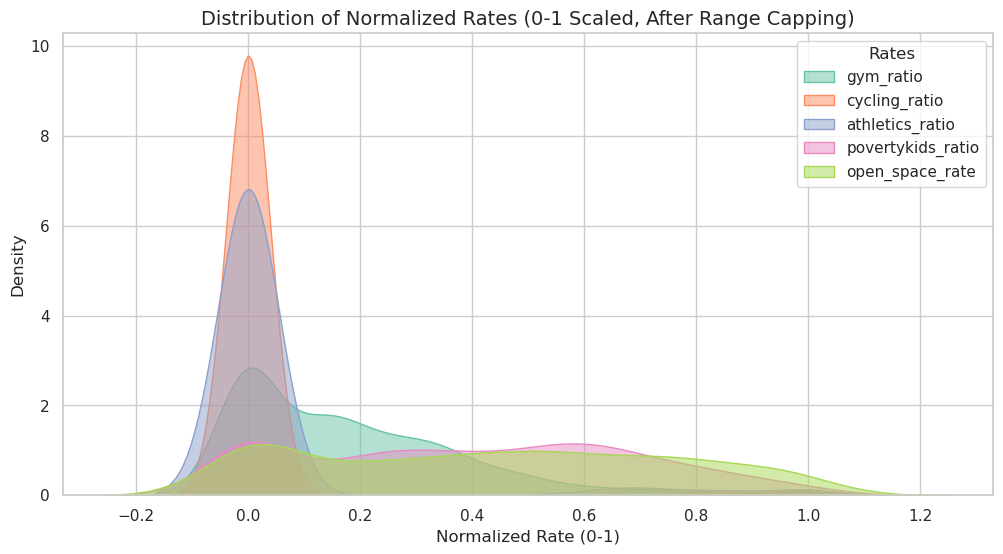

In [192]:
from sklearn.preprocessing import MinMaxScaler  
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  

# 选择需要分析的列  
ratios = ["gym_ratio", "cycling_ratio", "athletics_ratio", "povertykids_ratio", "open_space_rate"]  

# 剔除上下 1% 的异常值  
final_result_cleaned = final_result.copy()  # 复制原数据  
for col in ratios:  
    final_result_cleaned[col] = final_result_cleaned[col].clip(  
        lower=final_result_cleaned[col].quantile(0.01),  
        upper=final_result_cleaned[col].quantile(0.99)  
    )  

# 归一化（0-1 范围）  
scaler = MinMaxScaler()  
normalized_data = pd.DataFrame(  
    scaler.fit_transform(final_result_cleaned[ratios]),  
    columns=ratios  
)  

custom_colors = sns.color_palette("Set2", len(ratios))  
# 绘制归一化后 KDE 图  
plt.figure(figsize=(12, 6))  
for i, col in enumerate(ratios):  
    sns.kdeplot(normalized_data[col], label=col, fill=True, color=custom_colors[i], alpha=0.5)  

plt.title("Distribution of Normalized Rates (0-1 Scaled, After Range Capping)", fontsize=14)  
plt.xlabel("Normalized Rate (0-1)", fontsize=12)  
plt.ylabel("Density", fontsize=12)  
plt.legend(title="Rates", loc="upper right")  
plt.show()

In [193]:
import pandas as pd  

# Load the data  
Obesity = pd.read_csv("data/MSOA_Ward_LA_Obesity.csv")  

# Clean "s" and percentage strings  
def clean_percentage(column):  
    """Remove percentage (%) signs and replace 's' with None, then convert to float."""  
    return column.str.replace('%', '', regex=False).replace('s', None).astype(float)  

# Clean relevant columns  
columns_to_clean = [  
    "Number_measured_1", "Number_measured_2",  
    "Number_excess_weight1", "Number_excess_weight2",  
    "Lower_95%confidence_limits", "Lower_95%confidence_limits.1",  
    "Upper_95%confidence_limits", "Upper_95%confidence_limits.1",  
]  

for col in columns_to_clean:  
    if Obesity[col].dtype == 'object':  # Clean strings only  
        Obesity[col] = clean_percentage(Obesity[col])  

# Step 1: Calculate total measured and total excess weight  
Obesity["Total_measured"] = Obesity["Number_measured_1"].fillna(0) + Obesity["Number_measured_2"].fillna(0)  
Obesity["Total_excess_weight"] = Obesity["Number_excess_weight1"].fillna(0) + Obesity["Number_excess_weight2"].fillna(0)  

# Avoid division by zero, and calculate Total_excess_rate  
Obesity["Total_excess_rate"] = Obesity["Total_excess_weight"] / Obesity["Total_measured"] * 100  
Obesity["Total_excess_rate"] = Obesity["Total_excess_rate"].replace([float('inf'), -float('inf')], 0)  

# Check results  
print(Obesity[["Total_measured", "Total_excess_weight", "Total_excess_rate"]].describe())  

# Step 2: Calculate confidence intervals  
Obesity["Lower_CI"] = Obesity[["Lower_95%confidence_limits", "Lower_95%confidence_limits.1"]].mean(axis=1)  
Obesity["Upper_CI"] = Obesity[["Upper_95%confidence_limits", "Upper_95%confidence_limits.1"]].mean(axis=1)  

# Check intervals  
print(Obesity[["Lower_CI", "Upper_CI"]].describe())  

# Select required columns  
Obesity_cleaned = Obesity[["Code", "Total_excess_rate", "Lower_CI", "Upper_CI"]]  
Obesity_cleaned = Obesity_cleaned.dropna()  
print(f"Rows after filtering: {Obesity_cleaned.shape[0]}")  

# Raise an error if filtered data is empty  
if Obesity_cleaned.shape[0] == 0:  
    raise ValueError("Obesity_cleaned is empty after cleaning! Please check the cleaning process.")  

# Step 4: Ensure keys are consistent and merge with final_result  
final_result["wd11cd"] = final_result["wd11cd"].astype(str)  
Obesity_cleaned["Code"] = Obesity_cleaned["Code"].astype(str)  

# Check for matching keys  
merged_keys = set(final_result["wd11cd"]) & set(Obesity_cleaned["Code"])  
print(f"Number of matching keys: {len(merged_keys)}")  

# Merge data  
merged_data = final_result.merge(Obesity_cleaned, left_on="wd11cd", right_on="Code", how="left")  
merged_data = merged_data.drop(columns=["Code"])  

# Output the merged results  
print("Final merged data:")  
print(merged_data.head())  

print(merged_data[["Total_excess_rate"]].describe())


       Total_measured  Total_excess_weight  Total_excess_rate
count    1.663000e+03          1663.000000        1657.000000
mean     4.778960e+03          1336.309681          28.492134
std      8.351553e+04         23042.325443           5.869995
min      0.000000e+00             0.000000           0.000000
25%      4.315000e+02           110.500000          25.400052
50%      5.870000e+02           168.000000          29.333333
75%      7.970000e+02           249.000000          32.352941
max      3.220336e+06        888410.000000          42.010309
          Lower_CI     Upper_CI
count  1644.000000  1644.000000
mean     24.586375    35.101338
std       5.336324     5.130962
min       6.200000    19.450000
25%      21.150000    31.800000
50%      25.200000    35.550000
75%      28.300000    38.650000
max      37.200000    55.200000
Rows after filtering: 1644
Number of matching keys: 569
Final merged data:
      wd11cd        wd11nm                                           geometry  

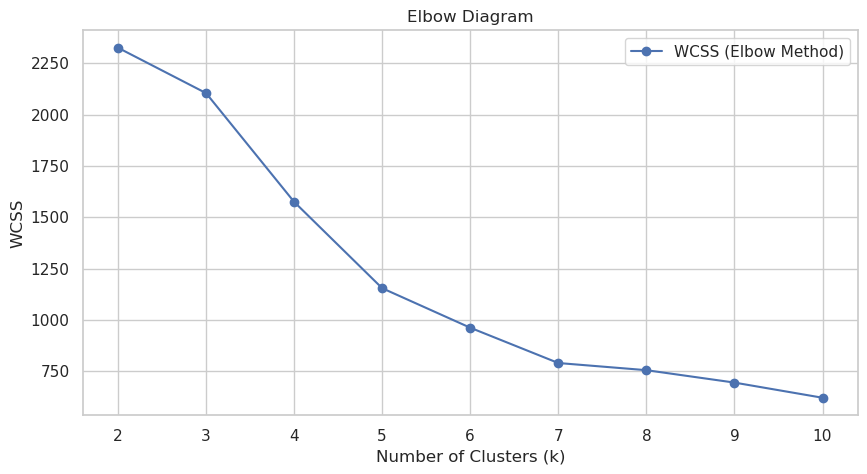

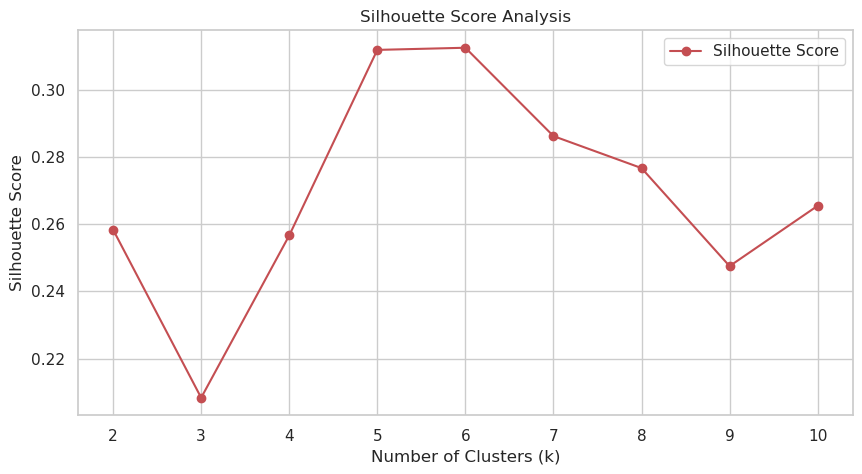


Average Obesity Rate per Cluster:
Cluster
0    29.032261
1    24.131401
2    28.281232
3    29.034339
4    31.871531
Name: Total_excess_rate, dtype: float64


/tmp/ipykernel_42713/3467736672.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Cluster", y=dependent_var, data=data_cleaned, palette="magma")


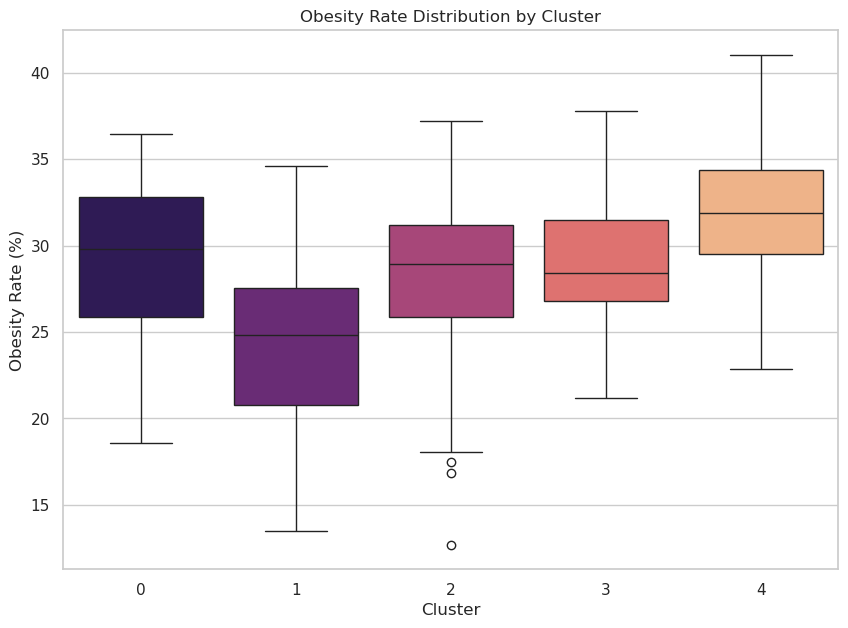

In [195]:
import pandas as pd  
import numpy as np  
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler  
from sklearn.decomposition import PCA  
from sklearn.metrics import silhouette_score  
import matplotlib.pyplot as plt  
import seaborn as sns  

# Step 1: Data Preparation  
# Select independent variables based on your data  
features = ["gym_ratio", "cycling_ratio", "athletics_ratio", "povertykids_ratio", "open_space_rate"]  
dependent_var = "Total_excess_rate"  

# Clean the data  
data_cleaned = merged_data.copy()  
data_cleaned = data_cleaned[["wd11cd"]+["wd11nm"]+features + [dependent_var]].dropna()  # Drop missing values  

# Normalize the independent variables  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(data_cleaned[features])  

# Step 2: Determine Optimal Number of Clusters  
wcss = []  # Within-cluster sum of squares  
silhouette_scores = []  
K_range = range(2, 11)  # Test clusters from 2 to 10  

for k in K_range:  
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(X_scaled)  
    wcss.append(kmeans.inertia_)  
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))  

# Plot WCSS (Elbow Diagram)  
plt.figure(figsize=(10, 5))  
plt.plot(K_range, wcss, 'bo-', label='WCSS (Elbow Method)')  
plt.xlabel('Number of Clusters (k)')  
plt.ylabel('WCSS')  
plt.title('Elbow Diagram')  
plt.legend()  
plt.show()  

# Plot Silhouette Scores  
plt.figure(figsize=(10, 5))  
plt.plot(K_range, silhouette_scores, 'ro-', label='Silhouette Score')  
plt.xlabel('Number of Clusters (k)')  
plt.ylabel('Silhouette Score')  
plt.title('Silhouette Score Analysis')  
plt.legend()  
plt.show()  

# Step 3: Fit the KMeans Model with Optimal Clusters (Example: k=4)  
optimal_k = 5  # Replace this based on the results of Elbow and Silhouette methods  
kmeans = KMeans(n_clusters=optimal_k, random_state=42)  
data_cleaned["Cluster"] = kmeans.fit_predict(X_scaled)  

# Step 4: Analyze Cluster Characteristics  
# Calculate average obesity rate per cluster  
cluster_obesity_summary = data_cleaned.groupby("Cluster")[dependent_var].mean()  
print("\nAverage Obesity Rate per Cluster:")  
print(cluster_obesity_summary)  

# Step 5: Visualize Cluster Obesity Rates  
# Boxplot of obesity rate by cluster  
plt.figure(figsize=(10, 7))  
sns.boxplot(x="Cluster", y=dependent_var, data=data_cleaned, palette="magma")  
plt.title("Obesity Rate Distribution by Cluster")  
plt.xlabel("Cluster")  
plt.ylabel("Obesity Rate (%)")  
plt.show()  

# Step 6: Add Cluster Info Back to Original Data  
merged_data["Cluster"] = np.nan  # Initialize cluster column  
merged_data.loc[data_cleaned.index, "Cluster"] = data_cleaned["Cluster"]  # Assign clusters

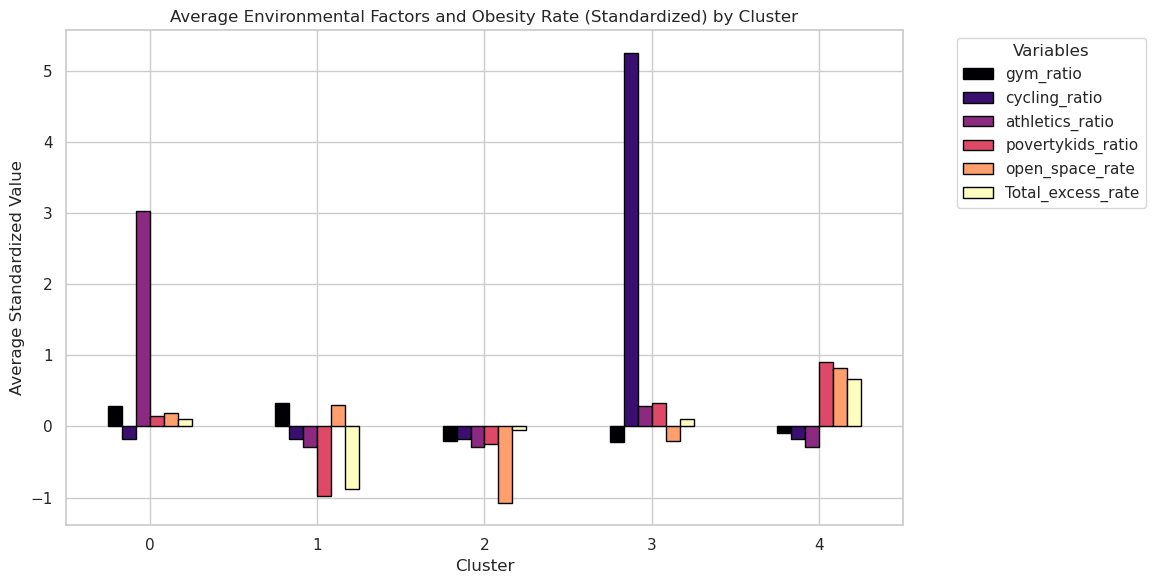

In [196]:
# 将肥胖率加入待标准化的特征列表  
features_with_target = features + [dependent_var]  # 添加肥胖率到变量列表中  

# 标准化所有变量（包括肥胖率）  
X_scaled_all = scaler.fit_transform(data_cleaned[features_with_target])  # 重新标准化所有变量  

# 将标准化后的数据转换为 DataFrame，保留列名和簇标签  
X_scaled_df_all = pd.DataFrame(X_scaled_all, columns=features_with_target, index=data_cleaned.index)  
X_scaled_df_all["Cluster"] = data_cleaned["Cluster"]  # 添加簇标签  

# 每个簇的标准化均值  
cluster_summary_standardized_all = X_scaled_df_all.groupby("Cluster").mean()  

# 绘制柱状图，包括所有变量  
cluster_summary_standardized_all.plot(  
    kind="bar", figsize=(12, 6), edgecolor="black", colormap="magma"  
)  
plt.title("Average Environmental Factors and Obesity Rate (Standardized) by Cluster")  
plt.xlabel("Cluster")  
plt.ylabel("Average Standardized Value")  
plt.legend(loc="upper right", title="Variables", bbox_to_anchor=(1.3, 1))  # 设置图例位置  
plt.xticks(rotation=0) 
plt.tight_layout()  
plt.show()

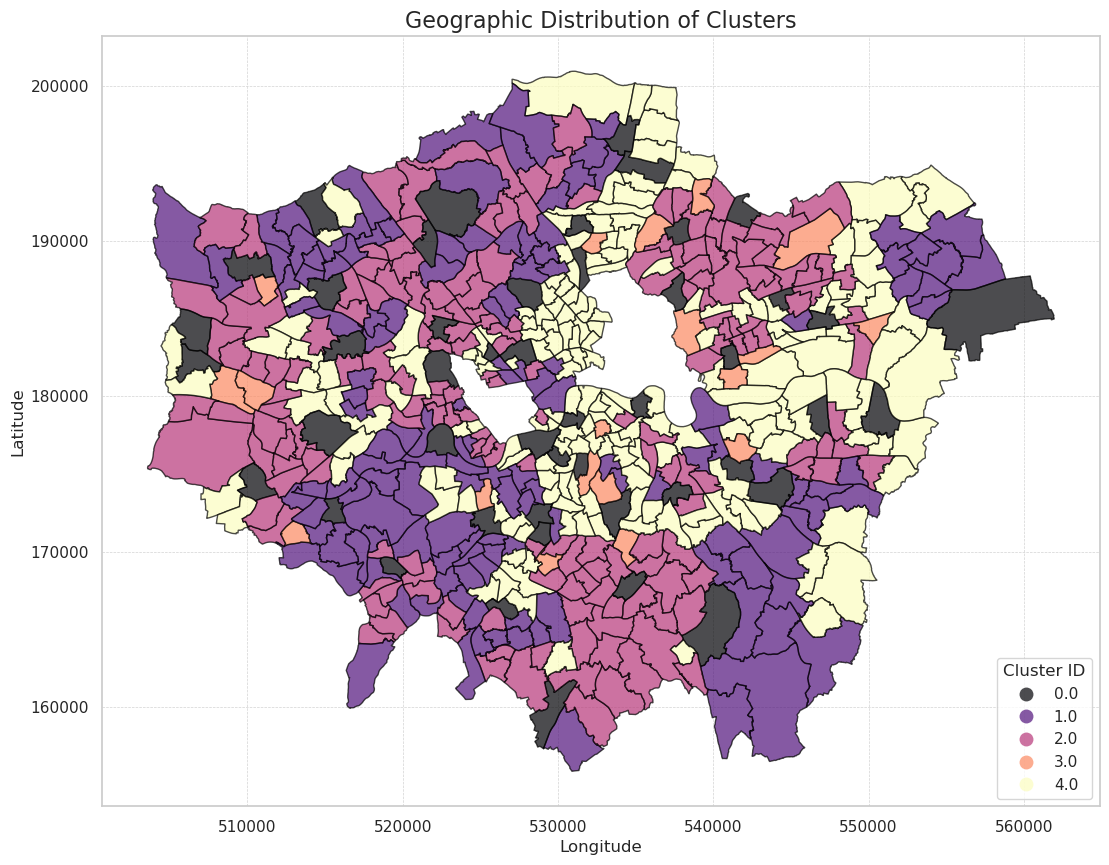

In [197]:
import geopandas as gpd  
import matplotlib.pyplot as plt  

# Step 1: Ensure 'Cluster' is a categorical variable  
geo_df['Cluster'] = geo_df['Cluster'].astype('category')  # Convert to category  

# Step 2: Plot the clusters on the map with discrete colors  
fig, ax = plt.subplots(1, 1, figsize=(14, 10))  
geo_df.plot(  
    column="Cluster",  # Use 'Cluster' for discrete coloring  
    cmap="magma",  # Use magma colormap  
    legend=True,  # Add a legend  
    legend_kwds={  
        'loc': 'lower right',  # Adjust legend location  
        'title': "Cluster ID"  # Title for legend  
    },  
    edgecolor="black",  # Add boundary color  
    alpha=0.7,  # Set transparency  
    ax=ax  # Use the same axis for customization  
)  

# Customize the map  
ax.set_title("Geographic Distribution of Clusters", fontsize=16)  
ax.set_xlabel("Longitude", fontsize=12)  
ax.set_ylabel("Latitude", fontsize=12)  
ax.grid(color="lightgray", linestyle="--", linewidth=0.5)  
plt.show()

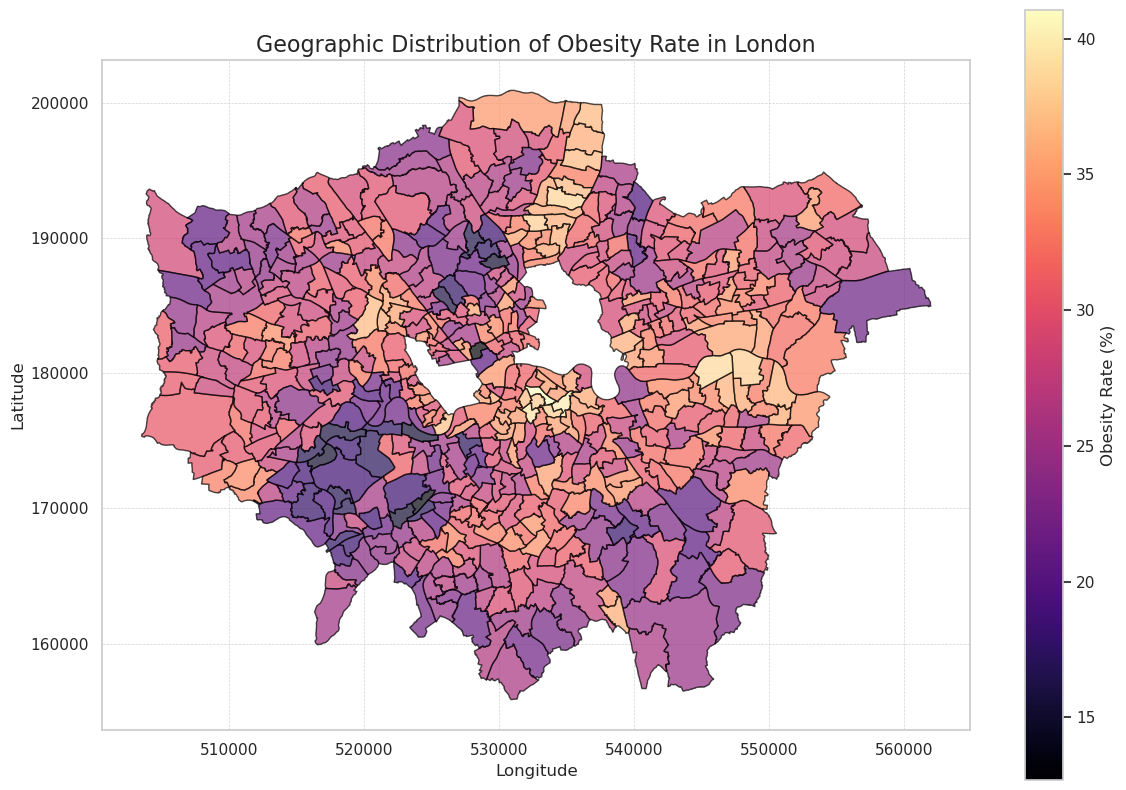

In [198]:

# Step 1: Plot obesity rate distribution  
fig, ax = plt.subplots(1, 1, figsize=(14, 10))  
geo_df.plot(  
    column="Total_excess_rate",  # Use obesity rate as the column for shading  
    cmap="magma",  # Use magma colormap  
    legend=True,  # Add a legend  
    legend_kwds={  
        'label': "Obesity Rate (%)",  
        'orientation': "vertical"  
    },  
    edgecolor="black",  # Add boundaries  
    alpha=0.7,  # Transparency  
    ax=ax  
)  

# Step 2: Customize the map  
ax.set_title("Geographic Distribution of Obesity Rate in London", fontsize=16)  
ax.set_xlabel("Longitude", fontsize=12)  
ax.set_ylabel("Latitude", fontsize=12)  
ax.grid(color="lightgray", linestyle="--", linewidth=0.5)  
plt.show()

 Cluster 4（浅黄色区域，肥胖率最高）
地理分布：
Cluster 4 集中在伦敦的东北部，包括 Barking 和 Dagenham 等地区，这些区域以经济相对落后、收入低和家庭贫困率高而著称。
关键特征：
肥胖率显著高（>35%）。
与较高的贫困儿童比例（povertykids_ratio）直接相关。
同时，这些地区的健身房密度（gym_ratio）和骑行设施（cycling_ratio）水平较低，可能限制了居民的运动机会。
2. 为什么 Cluster 4 集中在东北部
结合实际与研究背景：

东北部是伦敦的传统工人阶级聚居地，经济资源分配不均，居民面临较高的社会经济压力。
健康资源（如健身房和活动设施）的分布通常向经济优越地区倾斜，这加剧了东北部居民健康管理的困难。
饮食习惯可能也受制于经济水平，居民更依赖于高脂肪、高热量但价格低廉的食品，进一步增加了肥胖风险。


Cluster 1（深紫色区域）肥胖率和贫困儿童比例最低，集中在伦敦中心的高收入住宅区（如 Chelsea 和 Kensington）。这些区域开放空间覆盖率高，居民健康意识和资源获取能力较强。
2. 环境资源对肥胖率的作用
骑行设施与肥胖率：
Cluster 0 和 Cluster 3 的骑行比例（cycling_ratio）和运动场比例（athletics_ratio）异常高，但肥胖率并未显著降低。这表明单纯增加运动设施可能不足以有效改善肥胖问题。
开放空间与肥胖率：
Cluster 2 的开放空间覆盖率最低，但肥胖率并未显著高于均值，提示开放空间的作用可能依赖于居民的实际利用率。
3. 地理分布的空间规律
肥胖率较高的区域（Cluster 4 和部分 Cluster 2）集中在伦敦东部和东南部，可能与这些区域的经济贫困和社会资源分布不均有关。
肥胖率较低的区域（Cluster 1）集中在伦敦中心和西部，这些区域资源丰富，居民更倾向于主动采用健康生活方式。

In [199]:
import pandas as pd  
import numpy as np  
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import statsmodels.api as sm  
import seaborn as sns  
import matplotlib.pyplot as plt
# Calculate VIF to test for multicollinearity  
def calculate_vif(data):  
    vif_data = pd.DataFrame()  
    vif_data["Variable"] = data.columns  
    vif_data["VIF"] = [  
        variance_inflation_factor(data.values, i)  
        for i in range(data.shape[1])  
    ]  
    return vif_data  

# Select predictor variables (independent variables X)  
X = data_cleaned[["gym_ratio", "cycling_ratio", "athletics_ratio", "povertykids_ratio", "open_space_rate"]]  

# Add constant for calculating VIF  
X_with_const = sm.add_constant(X)  

# Calculate VIF values  
vif_results = calculate_vif(X_with_const)  
print(vif_results)

            Variable       VIF
0              const  7.837065
1          gym_ratio  1.011204
2      cycling_ratio  1.011440
3    athletics_ratio  1.011690
4  povertykids_ratio  1.092774
5    open_space_rate  1.091229


In [200]:
import statsmodels.api as sm  
import pandas as pd  

# Step 1: Define dependent and independent variables  
X = data_cleaned[["gym_ratio", "cycling_ratio", "athletics_ratio", "povertykids_ratio", "open_space_rate"]]  
y = data_cleaned["Total_excess_rate"]  

# Add a constant for the intercept in the regression model  
X = sm.add_constant(X)  

# Step 2: Fit the multiple linear regression model  
model = sm.OLS(y, X).fit()  

# Step 3: Print the regression results  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Total_excess_rate   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     164.8
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          9.43e-108
Time:                        02:18:00   Log-Likelihood:                -1468.6
No. Observations:                 569   AIC:                             2949.
Df Residuals:                     563   BIC:                             2975.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.8587      0.37

# Remove the varaibles that are not significant:

In [201]:
import statsmodels.api as sm  
import pandas as pd  

# Step 1: Define dependent and independent variables  
X = data_cleaned[["gym_ratio", "povertykids_ratio", "open_space_rate"]]  
y = data_cleaned["Total_excess_rate"]  

# Add a constant for the intercept in the regression model  
X = sm.add_constant(X)  

# Step 2: Fit the multiple linear regression model  
model = sm.OLS(y, X).fit()  

# Step 3: Print the regression results  
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Total_excess_rate   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     274.6
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          6.77e-110
Time:                        02:18:07   Log-Likelihood:                -1469.2
No. Observations:                 569   AIC:                             2946.
Df Residuals:                     565   BIC:                             2964.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                20.8361      0.37

In [202]:
# Plot a QQ plot to check normality of residuals  
residuals = model.resid  
sm.qqplot(residuals, line="45")  
plt.title("QQ Plot of Residuals")  
plt.show()  

# Plot residuals vs. fitted values to check homoscedasticity  
fitted_values = model.fittedvalues  
plt.scatter(fitted_values, residuals, alpha=0.5)  
plt.axhline(0, color="r", linestyle="--", linewidth=2)  
plt.xlabel("Fitted Values")  
plt.ylabel("Residuals")  
plt.title("Residuals vs. Fitted Values")  
plt.show()

SyntaxError: invalid non-printable character U+00A0 (1286131040.py, line 5)

# LP Model

<Axes: >

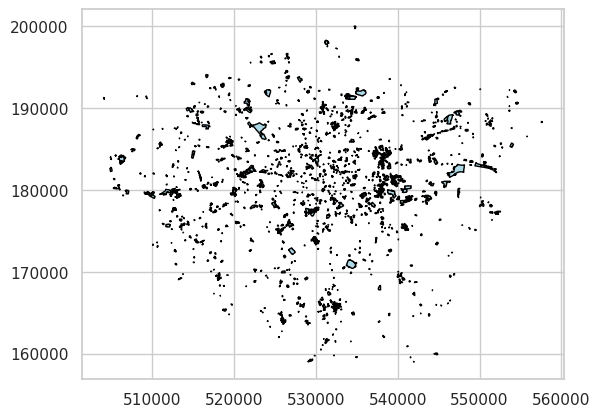

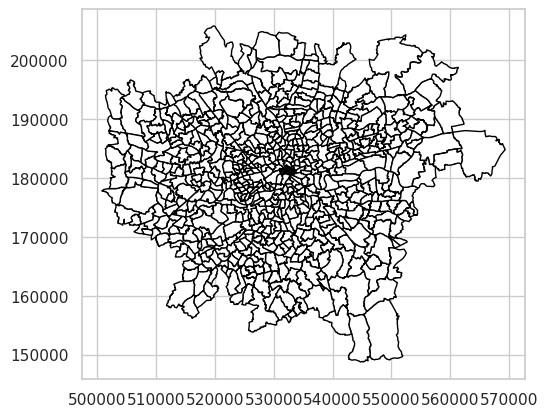

In [223]:
import geopandas as gpd  

# 加载已提供的“可用土地” shapefile 数据  
available_land = gpd.read_file("data/SHLAA/London_SHLAA_2017_approvals_and_allocations.shp")  

# 确保两份数据的坐标系一致（投影）  
available_land = available_land.to_crs(epsg=27700)  # 投影到 EPSG:27700 适合测量面积  
wards = wards.to_crs(epsg=27700)  

# 可加载绘制地图，确认数据正确加载  
available_land.plot(color="lightblue", edgecolor="black")  
wards.plot(color="white", edgecolor="black")

In [224]:
# 计算交集：裁剪可用土地数据到每个 ward 范围内  
land_in_wards = gpd.overlay(available_land, wards, how="intersection")  

# 计算裁剪后的可用土地面积（单位为平方米）  
land_in_wards["area"] = land_in_wards.geometry.area  

# Ensure land_area_by_ward has correct columns  
land_area_by_ward = land_in_wards.groupby("wd11cd")["area"].sum().reset_index()  

# Merge datasets with explicit suffixes  
data_cleaned = data_cleaned.merge(land_area_by_ward, on="wd11cd", how="left", suffixes=("_original", "_new"))  

data_cleaned["area"] = data_cleaned["area_original"].fillna(data_cleaned["area_new"])  
data_cleaned = data_cleaned.drop(columns=["area_original", "area_new"])  

data_cleaned["area"] = data_cleaned["area"].fillna(0)  

print(data_cleaned.head())

      wd11cd          wd11nm  gym_ratio  cycling_ratio  athletics_ratio  \
0  E05000026           Abbey   0.724323            0.0              0.0   
1  E05000027          Alibon   0.949938            0.0              0.0   
2  E05000028       Becontree   0.822707            0.0              0.0   
3  E05000029  Chadwell Heath   0.974564            0.0              0.0   
4  E05000030       Eastbrook   3.737968            0.0              0.0   

   povertykids_ratio  open_space_rate  Total_excess_rate  Cluster  \
0           0.282857             70.7          30.875976        4   
1           0.374545              8.0          29.931305        2   
2           0.366129             39.2          34.278351        4   
3           0.330000             63.1          31.914894        4   
4           0.288636             56.7          30.809399        4   

           area  
0  32302.825367  
1      0.000000  
2      0.000000  
3  71823.528361  
4      0.000000  


In [281]:
from pulp import LpMaximize, LpProblem, LpVariable, lpSum  

# Step 1: 定义线性规划问题  
model = LpProblem(name="resource-allocation", sense=LpMaximize)  

# Step 2: 定义变量  
n_regions = len(data_cleaned)  
x = [LpVariable(f"x_{i}", lowBound=0) for i in range(n_regions)]  
y = [LpVariable(f"y_{i}", lowBound=0) for i in range(n_regions)]  
z = [LpVariable(f"z_{i}", lowBound=0) for i in range(n_regions)]  

# Step 3: 定义目标函数  
# 回归模型中的权重（a1, a2, a3）  
a1 = -0.1999  # gym_ratio 的回归系数  
a2 = 40.4847  # povertykids_ratio 的回归系数  
a3 = -0.0122  # open_space_rate 的回归系数  

model += lpSum(a1 * x[i] + a2 * y[i] + a3 * z[i] for i in range(n_regions)), "Objective"

# Step 4: 添加约束条件  
# (1) 总预算限制  
c1, c2, c3 = 47.5 ,30000, 500  # 假设单位成本（健身房，贫困家庭、绿地）  
budget = 10000000  # 总预算  
model += lpSum(c1 * x[i] + c2 * y[i] + c3 * z[i] for i in range(n_regions)) <= budget, "BudgetConstraint"  
 
# (2) 土地利用限制  
available_land = data_cleaned["area"]  # 每个区域的可用土地面积  
for i in range(n_regions):  
    model += z[i] <= available_land[i], f"LandConstraint_{i}"  

# (3) 高肥胖率区域优先  
high_obesity_regions = data_cleaned["Total_excess_rate"] > 30  
for i in range(n_regions):  
    if high_obesity_regions[i]:  
        model += x[i] + y[i] + z[i] >= 10, f"HighObesityPriority_{i}"  # 高肥胖率区域最低资源分配  

# Step 5: 求解模型  
model.solve()  

# Step 6: 输出结果  
print("Optimization Results:")  
for i in range(n_regions):  
    print(f"Region {i}: Gym={x[i].value()}, Poverty_family={y[i].value()}, GreenSpace={z[i].value()}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/96a25ebf32fa4baab0a8b2cd62864e9f-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/96a25ebf32fa4baab0a8b2cd62864e9f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 812 COLUMNS
At line 5507 RHS
At line 6315 BOUNDS
At line 6316 ENDATA
Problem MODEL has 807 rows, 1707 columns and 2987 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 238 (-569) rows, 668 (-1039) columns and 1335 (-1652) elements
Perturbing problem by 0.001% of 8.0757713 - largest nonzero change 9.4329246e-05 ( 0.088705608%) - largest zero change 0
0  Obj -0 Primal inf 10747.078 (238) Dual inf 1922.0168 (238)
76  Obj 13424.286 Primal inf 2106.3269 (178)
128  Obj 13337.03 Primal inf 1728.8194 (145)
197  Obj 13191.6 Primal inf 1183.1919 (90)
273  Obj 

In [282]:
data_cleaned = data_cleaned.reset_index(drop=True) 
# 提取优化结果并记录到 DataFrame  
optimized_results = []  
for i in range(n_regions):  
    optimized_results.append({  
        "wd11cd": data_cleaned["wd11cd"][i],  # 选区的 ID 
        "wd11nm": data_cleaned["wd11nm"][i],
        "Cluster": data_cleaned["Cluster"][i],  # 聚类标记 (如 Cluster 4)  
        "Gym": x[i].value(),  # Fitness/Gym 分配量  
        "Poverty_family": y[i].value(),  # 贫困家庭支援分配量  
        "GreenSpace": z[i].value()  # 绿地分配量  
    })  

# 转换为 DataFrame  
optimized_results = pd.DataFrame(optimized_results)  

# 保存为 CSV 文件，便于进一步分析或可视化  
optimized_results.to_csv("optimized_results.csv", index=False)  

# 检查结果  
print(optimized_results)

        wd11cd          wd11nm  Cluster   Gym  Poverty_family  GreenSpace
0    E05000026           Abbey        4  10.0             0.0         0.0
1    E05000027          Alibon        2   0.0             0.0         0.0
2    E05000028       Becontree        4  10.0             0.0         0.0
3    E05000029  Chadwell Heath        4  10.0             0.0         0.0
4    E05000030       Eastbrook        4  10.0             0.0         0.0
..         ...             ...      ...   ...             ...         ...
564  E05000645       Tachbrook        4   0.0            10.0         0.0
565  E05000646  Vincent Square        4   0.0             0.0         0.0
566  E05000647         Warwick        2  10.0             0.0         0.0
567  E05000648      Westbourne        4   0.0            10.0         0.0
568  E05000649        West End        1   0.0             0.0         0.0

[569 rows x 6 columns]


In [283]:
# 标注高肥胖率区域（Cluster == 4）  
optimized_results["is_high_obesity"] = optimized_results["Cluster"] == 4  

# 查询高肥胖率区域的结果  
high_obesity_results = optimized_results[optimized_results["is_high_obesity"]]  

# 导出高肥胖率区域结果供检查  
high_obesity_results.to_csv("high_obesity_results.csv", index=False)  

# 打印结果  
print(high_obesity_results)

        wd11cd          wd11nm  Cluster        Gym  Poverty_family  \
0    E05000026           Abbey        4  10.000000        0.000000   
2    E05000028       Becontree        4  10.000000        0.000000   
3    E05000029  Chadwell Heath        4  10.000000        0.000000   
4    E05000030       Eastbrook        4  10.000000        0.000000   
5    E05000031        Eastbury        4   9.896503        0.103497   
..         ...             ...      ...        ...             ...   
555  E05000635     Harrow Road        4  10.000000        0.000000   
561  E05000642    Queen's Park        4  10.000000        0.000000   
564  E05000645       Tachbrook        4   0.000000       10.000000   
565  E05000646  Vincent Square        4   0.000000        0.000000   
567  E05000648      Westbourne        4   0.000000       10.000000   

     GreenSpace  is_high_obesity  
0           0.0             True  
2           0.0             True  
3           0.0             True  
4           0.0    

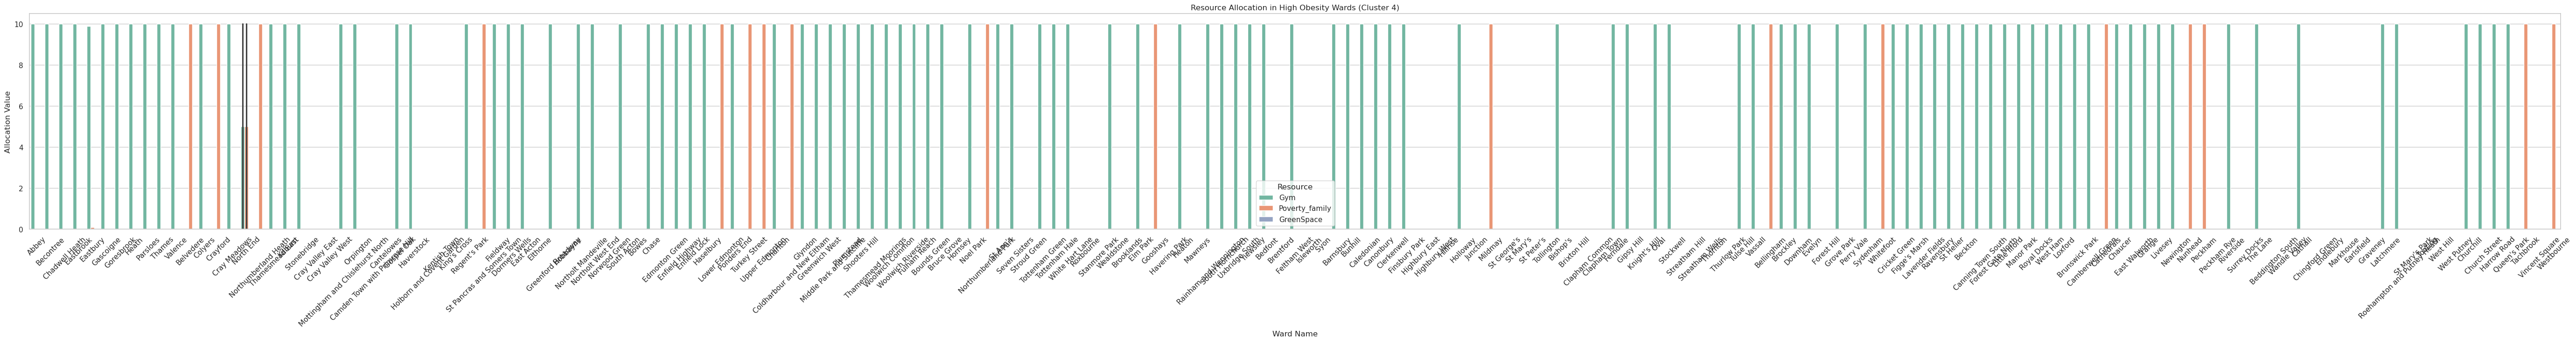

In [284]:
import matplotlib.pyplot as plt  
import seaborn as sns  

# 长格式转换，用于 Seaborn 条形图可视化  
high_obesity_long = high_obesity_results.melt(  
    id_vars="wd11nm",  
    value_vars=["Gym", "Poverty_family", "GreenSpace"],  
    var_name="Resource",  
    value_name="Value"  
)  

# 绘制条形图  
plt.figure(figsize=(70, 6))  
sns.barplot(  
    data=high_obesity_long,  
    x="wd11nm", y="Value", hue="Resource",  
    palette="Set2"  
)  
plt.xticks(rotation=45)  
plt.title("Resource Allocation in High Obesity Wards (Cluster 4)")  
plt.ylabel("Allocation Value")  
plt.xlabel("Ward Name")  
plt.legend(title="Resource")  
plt.savefig('plots/Resource Allocation in High Obesity Wards', dpi=300, bbox_inches='tight')  
plt.show()

In [285]:
# 检查 GreenSpace 数据范围  
print(ward_boundaries["GreenSpace"].describe())  

# 查看是否有缺失值  
print(ward_boundaries["GreenSpace"].isnull().sum())  
print(ward_boundaries["is_high_obesity"].isnull().sum())  

# 填充缺失值（若有需要）  
ward_boundaries["GreenSpace"] = ward_boundaries["GreenSpace"].fillna(0)

count    569.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: GreenSpace, dtype: float64
157
0


/tmp/ipykernel_42713/466979775.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ward_boundaries["is_high_obesity"] = ward_boundaries["is_high_obesity"].fillna(False)


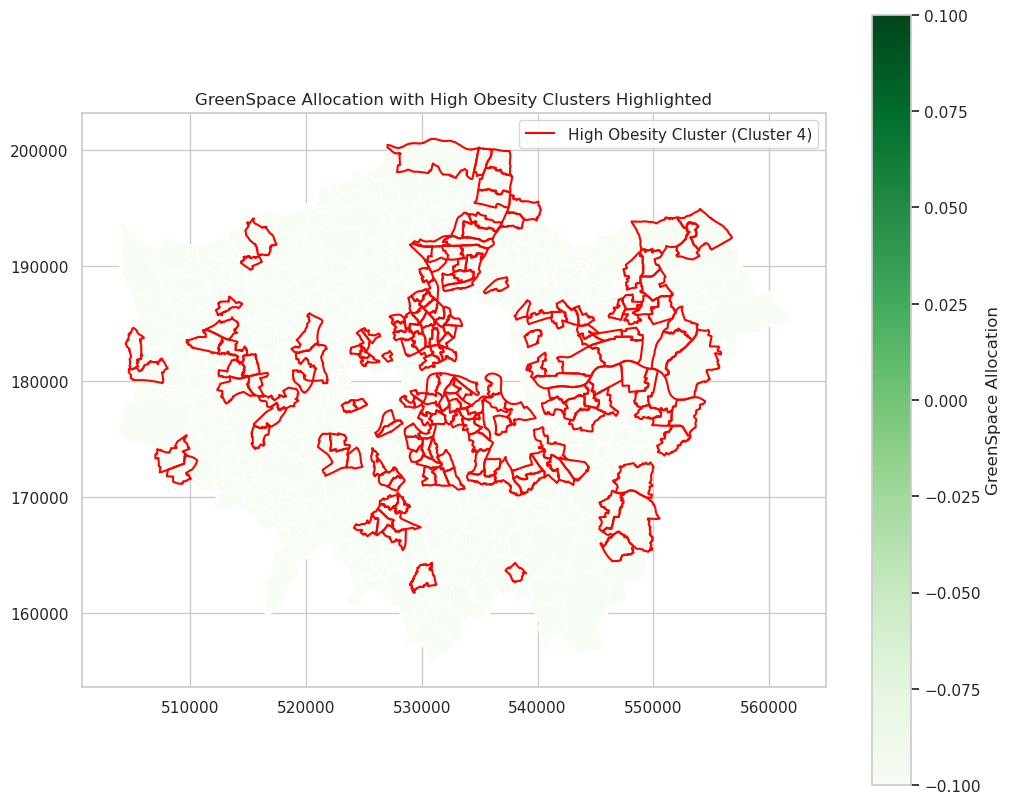

In [286]:
ward_boundaries = wards.merge(optimized_results, on="wd11cd", how="left")  
# 填充 `is_high_obesity` 中可能的 NaN 值为 False（默认非高肥胖率区域）  
ward_boundaries["is_high_obesity"] = ward_boundaries["is_high_obesity"].fillna(False)
# 绘制地图并突出高肥胖率区域（Cluster 4）  
fig, ax = plt.subplots(1, 1, figsize=(12, 10))  
ward_boundaries.plot(  
    column="GreenSpace", cmap="Greens", legend=True,  
    legend_kwds={"label": "GreenSpace Allocation"},  
    ax=ax  
)  
ward_boundaries[ward_boundaries["is_high_obesity"]].boundary.plot(  
    color="red", ax=ax, linewidth=1.5, label="High Obesity Cluster (Cluster 4)"  
)  
plt.title("GreenSpace Allocation with High Obesity Clusters Highlighted")  
plt.legend()  
plt.show()